# Laser vs ablation from network matrices

**Hypothesis**: Structural brain networks are different between patients who are seizure free after surgery from laser ablation vs resection in temporal lobe epilepsy.


In [1]:
import pandas as pd 
import numpy as np
import os
import sys
import dataload
import networkmetric as network
import matplotlib.pyplot as plt
import seaborn as sns
import t1mri_processor as t1

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline

ModuleNotFoundError: No module named 'h5py'

## Import Data

1. **Project Path Identification**: Identify project's root directory.

2. **Metadata Import**: Read metadata from Excel file in 'data/metadata' directory.

3. **Freesurfer Data Import**: Read Freesurfer data from Excel file in 'data/derivatives' directory.

4. **Connectivity Data Import**: Read connectivity data from HDF5 file in 'data/derivatives' directory.


In [9]:
# Import all paths
project_path = os.path.dirname(os.getcwd())

# Get metadata as pandas dataframe
metadata_path = os.path.join(project_path, 'data' ,'metadata', 'metadataCAPES.xlsx')
metadata = pd.read_excel(metadata_path)
metadata.set_index('record_id', inplace=True)

# Get freesurfer data as pandas dataframe
freesurfer_path = os.path.join(project_path, 'data', 'derivatives', 'freesurferStats.xlsx')
roi_volume = dataload.get_roi_volume(freesurfer_path)
roi_volume.set_index('record_id', inplace=True)

connectivity_path = os.path.join(project_path, 'data', 'derivatives', 'connectivity_capes.h5') 
connectivity = dataload.h5_to_dataframe(connectivity_path)
connectivity.set_index('record_id', inplace=True)


## Graph theory based network measures
Clean connectivity matrices and calculate network measures

In [10]:
connectivity_clean = network.cleanNetwork(connectivity)

try:
    network_metrics_path = os.path.join(project_path, 'data', 'derivatives', 'network_metrics.pkl')
    network_metrics = pd.read_pickle(network_metrics_path)
except FileNotFoundError:
    network_metrics = network.calculateNetworkMetrics(connectivity_clean)
    network_metrics.to_pickle(os.path.join(project_path, 'data', 'derivatives', 'network_metrics.pkl'))

## T1 MRI Processing

This section focuses on the processing of T1 MRI data and aims to quantify abnormality in individual ROIs using normative modeling.

**Harmonization with Combat GAM**: To ensure comparability across subjects, we apply harmonization using the combat generalized additive model (GAM) on the entire dataset. However, we preserve the effects of sex, epilepsy status, age, and epilepsy duration during the harmonization process.

In [11]:
#  Harmonization with Combat GAM
metadata['SITE'] = metadata.index.str[4:7]
roi_volume_harmonized = t1.harmonize_roi_volume(roi_volume, metadata)


[neuroHarmonize]: smoothing more than 10 variables may take several minutes of computation.


**Test the Effectiveness of Harmonization**: After applying harmonization, we perform tests to evaluate the effectiveness of the harmonization process. This step helps us ensure that the harmonization has successfully removed unwanted variability while preserving the relevant factors.

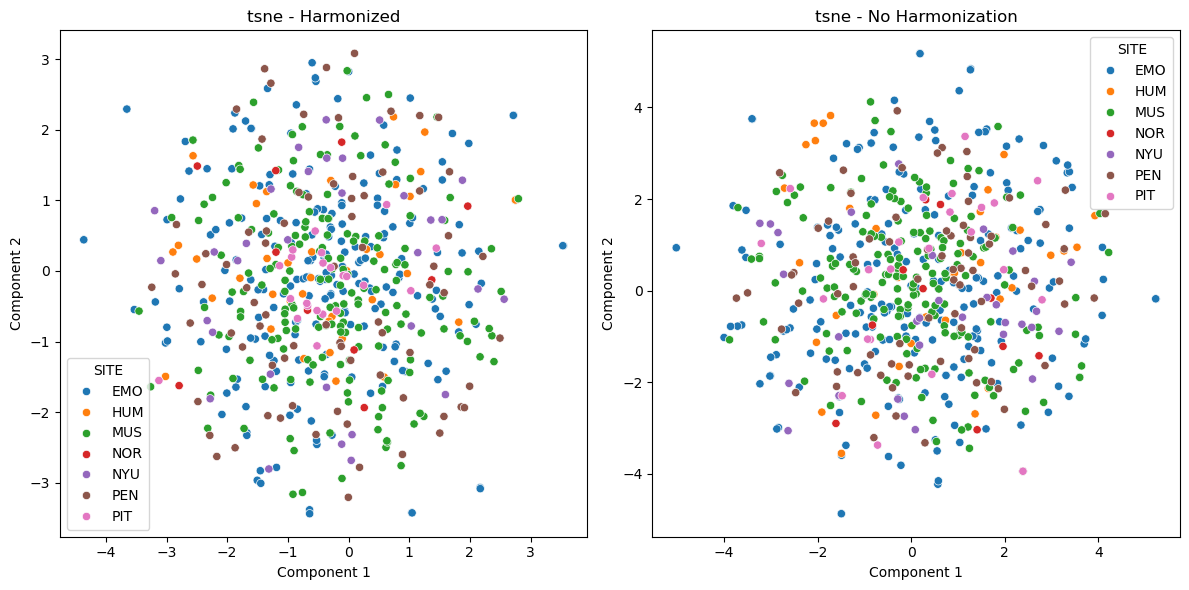

In [12]:
t1.visualize_harmonization(roi_volume.iloc[:,5:], roi_volume_harmonized.iloc[:,5:], metadata['SITE'])

**Robust Regression for Age and Sex Correction**: To account for the effects of age and sex, we employ robust regression techniques. This correction step helps us mitigate any confounding factors that may influence the analysis.

**Computing Z-Scores for Each ROI**: Once the necessary corrections are applied, we compute z-scores for each ROI. This step allows us to quantify the abnormality of individual ROIs relative to the normative population.

In [13]:
not_harmonized = roi_volume.iloc[:,5:]
harmonized = roi_volume_harmonized.iloc[:,5:]
batch = metadata['SITE']

# Binarize the output labels for multi-class ROC
classes = np.unique(batch)
y_true_bin = label_binarize(batch, classes=classes)

In [15]:
# Define the classifier
weak_learner = tree.DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300
clf = make_pipeline(StandardScaler(),
    OneVsRestClassifier(AdaBoostClassifier(estimator=weak_learner,
                                           n_estimators=n_estimators,
                                           algorithm="SAMME",
                                           random_state=42)))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                                  estimator=DecisionTreeClassifier(max_leaf_nodes=8),
                                                                  n_estimators=300,
                                                                  random_state=42)))])

In [23]:
# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform Leave-One-Out Cross-Validation and collect predictions
y_pred = cross_val_predict(clf, not_harmonized, batch, cv=kf, method='predict',n_jobs=8,verbose=2)
y_pred_proba = cross_val_predict(clf, not_harmonized, batch, cv=kf, method='predict_proba',n_jobs=8,verbose=2)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   43.9s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   49.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   44.7s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   52.3s finished


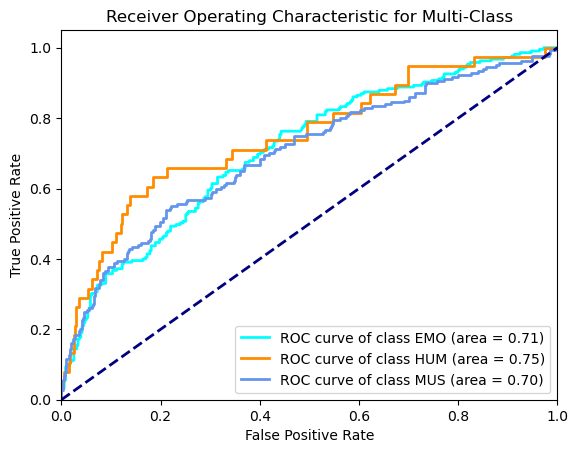

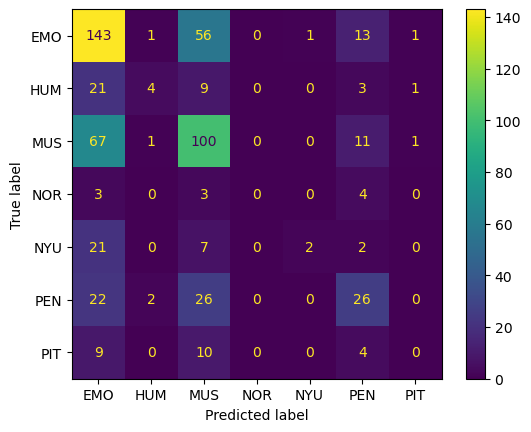

In [25]:
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(batch, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

In [26]:
# Perform Leave-One-Out Cross-Validation and collect predictions
y_pred = cross_val_predict(clf, harmonized, batch, cv=kf, method='predict',n_jobs=8,verbose=2)
y_pred_proba = cross_val_predict(clf, harmonized, batch, cv=kf, method='predict_proba',n_jobs=8,verbose=2)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   51.2s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   53.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   55.4s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   55.9s finished


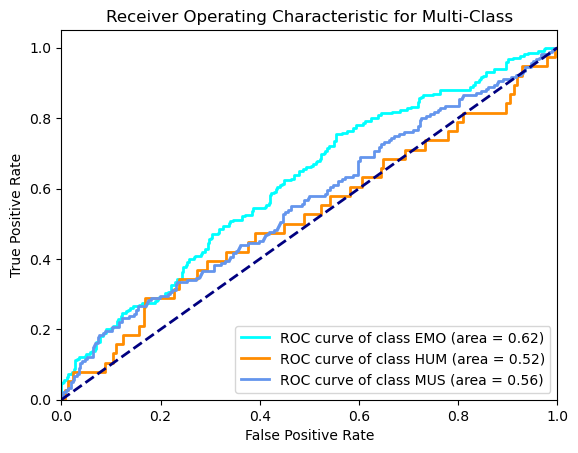

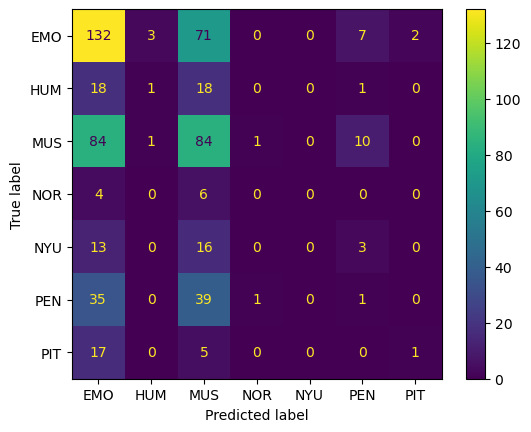

In [27]:
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(batch, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()